In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt

In [7]:
X = pd.read_hdf('../data/features/filtered/filtered_0.05_.h5')
y = pd.read_hdf('../data/ach_at_combined_y.h5', key='y')
y_bin = y.astype('category')
y_bin = pd.get_dummies(y_bin)

In [8]:
# ADD SUBJECT COLUMN
s = 1
for i in range(1,6):
    X.loc[90*(i-1):90*i,'subject'] = s
    s += 1
for i in range(1,7):
    X.loc[450+(60*(i-1)):450+(60*i),'subject'] = s
    s+=1
assert not any(pd.isna(X['subject']))

In [9]:
train = X[X['subject'] != 4].index
test = X[X['subject'] == 4].index

qt = QuantileTransformer(n_quantiles=10)
X = qt.fit_transform(X)
X = pd.DataFrame(X)

X_train, X_test, y_train, y_test = X.iloc[train,:], X.iloc[test,:], y_bin.iloc[train,:], y_bin.iloc[test,:]

In [10]:
hyper_par = np.logspace(-4, 4, 21)
auc0 = list()
auc1 = list()
auc2 = list()
coef0 = list()
coef1 = list()
coef2 = list()

for c in hyper_par:
    clf0 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf1 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf2 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf0.fit(X_train, y_train.iloc[:,0])
    clf1.fit(X_train, y_train.iloc[:,1])
    clf2.fit(X_train, y_train.iloc[:,2])
    p0 = clf0.predict_proba(X_test)[:,1]
    p1 = clf1.predict_proba(X_test)[:,1]
    p2 = clf2.predict_proba(X_test)[:,1]
    auc0.append(roc_auc_score(y_test.iloc[:,0], p0))
    auc1.append(roc_auc_score(y_test.iloc[:,1], p1))
    auc2.append(roc_auc_score(y_test.iloc[:,2], p2))
    coef0.append(clf0.coef_)
    coef1.append(clf1.coef_)
    coef2.append(clf2.coef_)

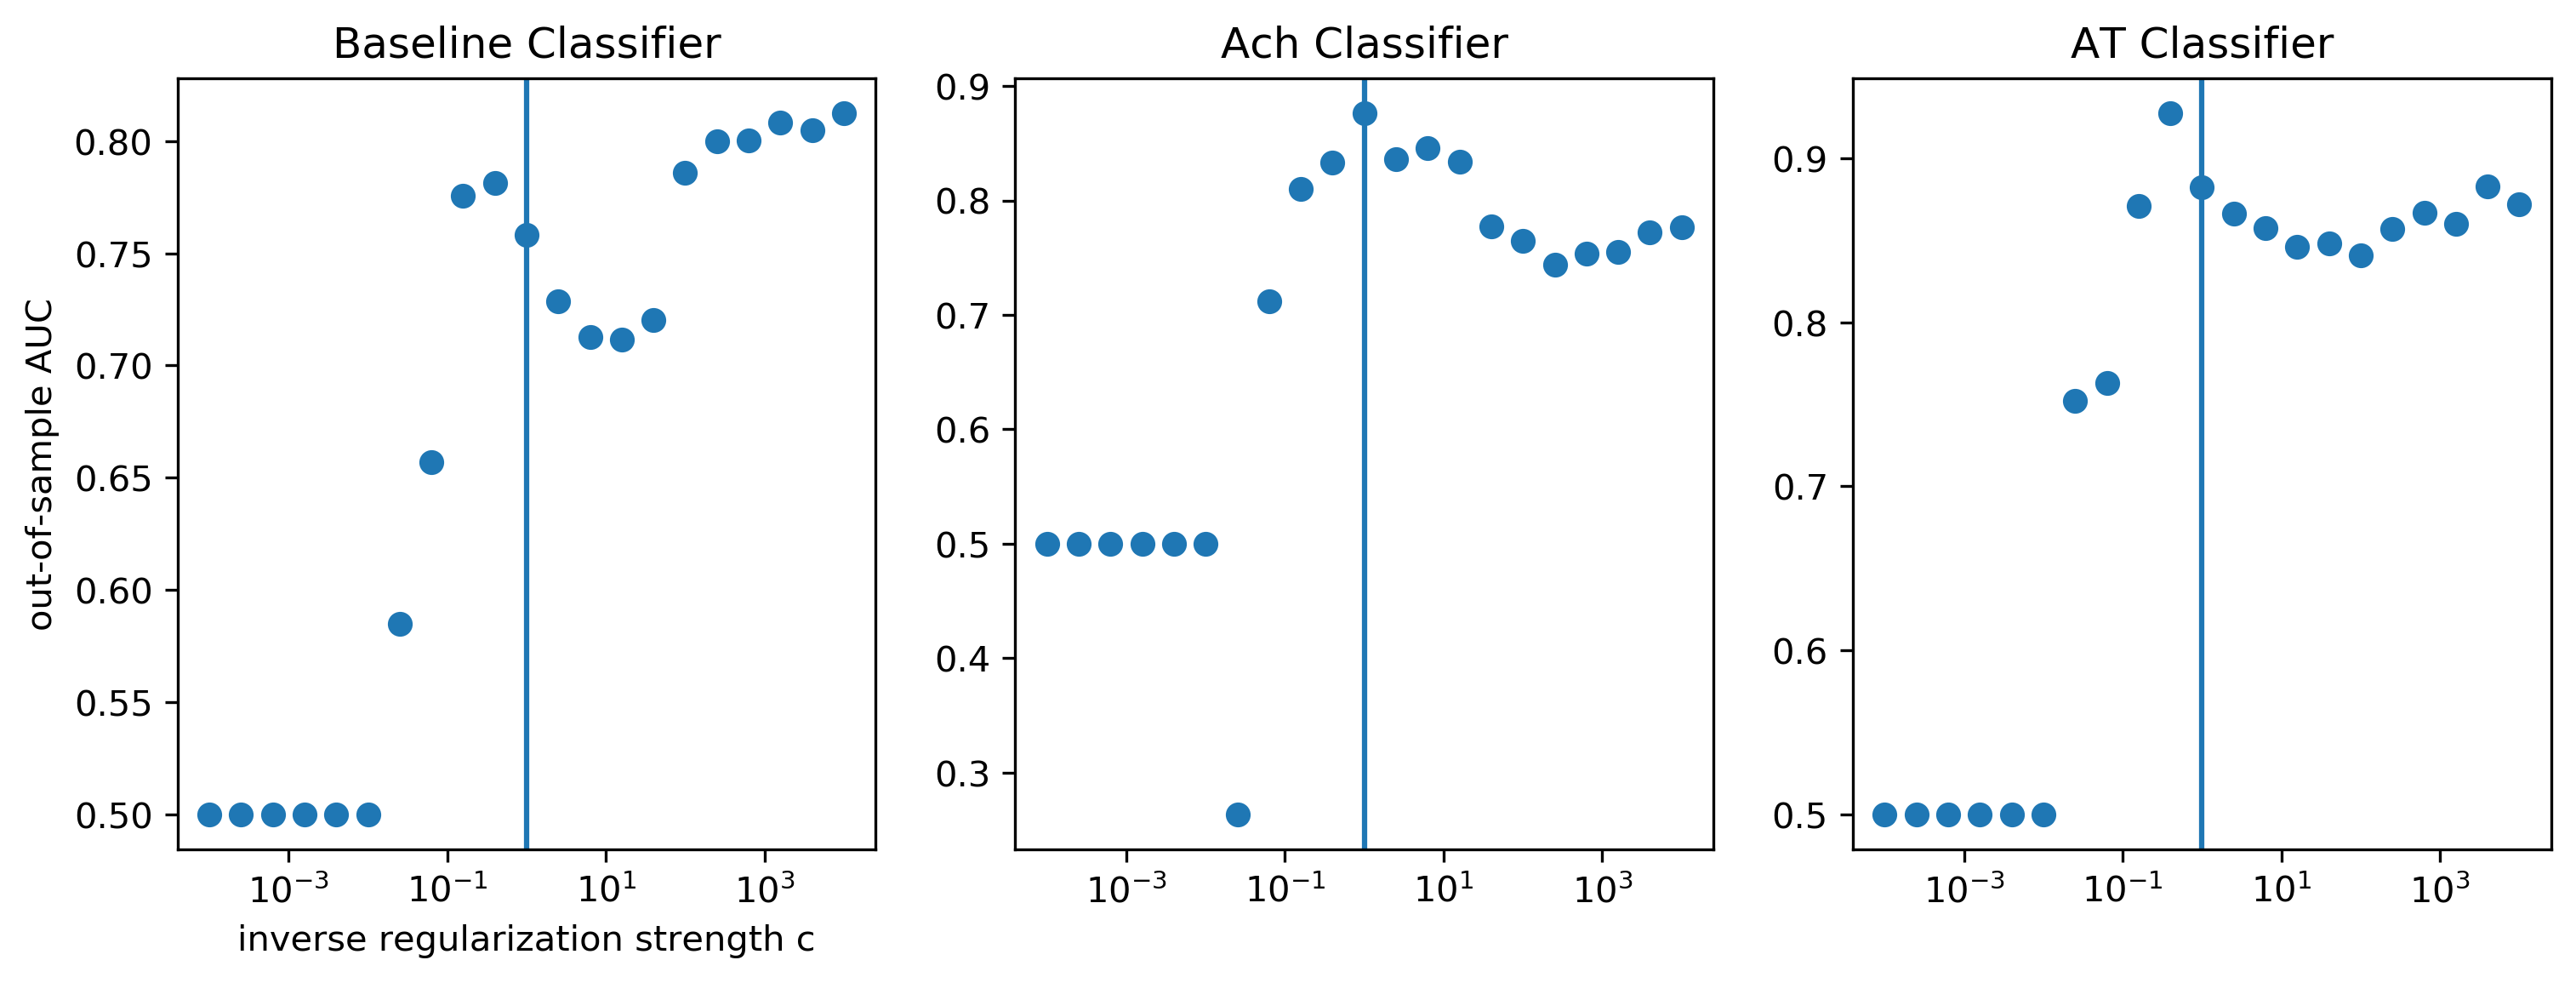

In [11]:
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(131)
plt.semilogx(hyper_par, auc0, 'o')
plt.axvline(1.0)
plt.xlabel('inverse regularization strength c')
plt.ylabel('out-of-sample AUC')
plt.title('Baseline Classifier')
plt.subplot(132)
plt.semilogx(hyper_par, auc1, 'o')
plt.axvline(1.0)
plt.title('Ach Classifier')
plt.subplot(133)
plt.semilogx(hyper_par, auc2, 'o')
plt.axvline(1.0)
plt.title('AT Classifier')
plt.savefig('../reports/figures/logregtuning.png')
plt.show()

In [7]:
clf2 = LogisticRegression(penalty='l1', C=0.398, solver='liblinear')
clf2.fit(X_train, y_train.iloc[:,2])
importance = pd.Series(abs(clf2.coef_[0]),index=X_train.columns)
importance.sort_values(ascending=False).head(10)

variable
2_56_diff__absolute_sum_of_changes         0.043429
48_46_diff__variance                       0.025533
51__max_langevin_fixed_point__m_3__r_30    0.010383
20__maximum                                0.009452
59__max_langevin_fixed_point__m_3__r_30    0.006868
11__max_langevin_fixed_point__m_3__r_30    0.004790
50__absolute_sum_of_changes                0.004026
57_59_diff__variance                       0.003791
1__max_langevin_fixed_point__m_3__r_30     0.003607
52_59_diff__variance                       0.002725
dtype: float64

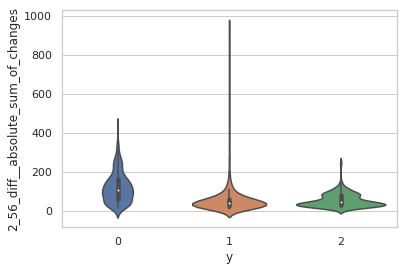

In [8]:
import seaborn as sns
df = X.join(y)
sns.set(style="whitegrid")
ax = sns.violinplot(x="y", y='2_56_diff__absolute_sum_of_changes', data=df)
fig = ax.get_figure()

In [9]:
from sklearn.model_selection import GridSearchCV, GroupKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf = RandomForestClassifier()
from pprint import pprint
pprint('Parameters currently in use:\n')
pprint(rf.get_params())

'Parameters currently in use:\n'
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [16]:
# cross-validation iterator
gkf = GroupKFold(n_splits=10)
gkf = list(gkf.split(X_train, y_train, X_train['subject']))

# hyperparameters
n_estimators = np.arange(100, 2000, 50)
max_depth = np.arange(5, 105, 10)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]

# parameter grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# one vs. rest scoring
scoring = 'roc_auc_ovr_weighted'
